# Accessing and analysing CaSR (RDRS) reanalysis data in the PAVICS JupyterLab

This notebook demonstrates how to access, subset, analyse and visualize Canadian Surface Reanalysis (CaSR) datasets (previously known as RDRS).

<div class="alert alert-block alert-info">
<b>Note</b> 
    The CaSR v2.1 data hosted on PAVICS has been reformated from the <a href="https://caspar-data.ca/">CaSPAr</a> version to improve its compatibility with <a href="https://docs.xarray.dev/en/stable/">xarray</a> and <a href="https://www.dask.org/">dask</a>. 
Key changes include:
<ul>
    <li> Renamed variable and converted units to match <a href="https://wcrp-cmip.org/cmip-model-and-experiment-documentation/">CMIP</a> conventions;</li>
    <li> Added the original variable name to variable attribute "original_variable";</li>
    <li> Modified NetCDF data structure (chunking) to improve performance for typical climate services workflows;</li>
    <li> Creation of a daily dataset.</li>
</ul>
</div>

The datasets are stored on the [PAVICS THREDDS server](https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/catalog/birdhouse/eccc/RDRS_v21/catalog.html). You'll find data at both hourly and daily frequencies. Hourly data are stored in individual files for each month and variable. Daily data are stored in files holding three years of data for each variable. 

For convenience, we provide [*NcML aggregations*](https://docs.unidata.ucar.edu/netcdf-java/current/userguide/ncml_overview.html), that is, single links for the [hourly](https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/catalog/datasets/reanalyses/catalog.html?dataset=datasets/reanalyses/1hr_RDRSv2.1_NAM.ncml) and [daily](https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/catalog/datasets/reanalyses/catalog.html?dataset=datasets/reanalyses/day_RDRSv2.1_NAM.ncml) datasets, combining multiple netCDF files (~500 files per variable for hourly data) into a single virtual dataset. The following demonstration uses those NcML aggregations.

## Data access

Here we start by opening the CaSR daily dataset using OPeNDAP, a data streaming protocol. The dataset holds temperature, precipitation, humidity, and pressure variables. See the attributes of each variable for more details.

It's critical here to specify a chunking pattern that makes sense for the analysis to follow. This is important for a couple of reasons. The first is that specifying chunks automatically triggers xarray to use dask, meaning that streaming and compute operations will be split into smaller, digestible chunks. This is need to distribute jobs across workers and threads, but it is also critical because OPeNDAP has limits on the volume of data that can be transferred in a query. Without chunking, chances are that many requests would reach that limit and raise an error.

In [1]:
import xarray as xr

url = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/reanalyses/day_RDRSv2.1_NAM.ncml"

# Open dataset. For hourly data, we suggest using the following chunking pattern: dict(time=720, rlon=50, rlat=50)
ds = xr.open_dataset(url, chunks=dict(time=1461, rlon=50, rlat=50))
ds

<xarray.Dataset> Size: 515GB
Dimensions:       (rlat: 800, rlon: 706, time: 14245)
Coordinates:
  * rlat          (rlat) float32 3kB -46.17 -46.08 -45.99 ... 25.56 25.65 25.74
  * rlon          (rlon) float32 3kB 324.6 324.7 324.8 ... 387.9 388.0 388.1
    rotated_pole  float32 4B ...
  * time          (time) datetime64[ns] 114kB 1980-01-01 ... 2018-12-31
    lat           (rlat, rlon) float32 2MB dask.array<chunksize=(50, 50), meta=np.ndarray>
    lon           (rlat, rlon) float32 2MB dask.array<chunksize=(50, 50), meta=np.ndarray>
Data variables: (12/19)
    lakeFrac      (rlat, rlon) float32 2MB dask.array<chunksize=(50, 50), meta=np.ndarray>
    sftlf         (rlat, rlon) float32 2MB dask.array<chunksize=(50, 50), meta=np.ndarray>
    sftof         (rlat, rlon) float32 2MB dask.array<chunksize=(50, 50), meta=np.ndarray>
    tas           (time, rlat, rlon) float32 32GB dask.array<chunksize=(1461, 50, 50), meta=np.ndarray>
    tasmin        (time, rlat, rlon) float32 32GB dask.array<chunksize=(1461, 50, 50), meta=np.ndarray>
    tasmax        (time, rlat, rlon) float32 32GB dask.array<chunksize=(1461, 50, 50), meta=np.ndarray>
    ...            ...
    hursmin       (time, rlat, rlon) float32 32GB dask.array<chunksize=(1461, 50, 50), meta=np.ndarray>
    hursmax       (time, rlat, rlon) float32 32GB dask.array<chunksize=(1461, 50, 50), meta=np.ndarray>
    hurs          (time, rlat, rlon) float32 32GB dask.array<chunksize=(1461, 50, 50), meta=np.ndarray>
    rsds          (time, rlat, rlon) float32 32GB dask.array<chunksize=(1461, 50, 50), meta=np.ndarray>
    rlds          (time, rlat, rlon) float32 32GB dask.array<chunksize=(1461, 50, 50), meta=np.ndarray>
    sfcWind       (time, rlat, rlon) float32 32GB dask.array<chunksize=(1461, 50, 50), meta=np.ndarray>
Attributes: (12/29)
    Conventions:          CF-1.8
    Notes:                Created from the Gem_geophy.fst file provided by Mi...
    doi:                  https://doi.org/10.5194/hess-25-4917-2021
    frequency:            fx
    license:              https://eccc-msc.github.io/open-data/licence/readme...
    organisation:         ECCC
    ...                   ...
    institute_id:         ECCC
    dataset_id:           RDRSv2.1
    abstract:             Environment and Climate Change Canada has initiated...
    dataset_description:  https://doi.org/10.5194/hess-25-4917-2021
    license_type:         permissive
    citation:             Gasset, N., Fortin, V., Dimitrijevic, M., Carrera, ...

## Data subsetting

We then subset the data for a zone and period of interest, namely eastern Canada for the period 1981-2010, using [clisops subset_bbox](https://clisops.readthedocs.io/en/latest/api.html#clisops.core.subset.subset_bbox) function. We also demonstrate how to select a single grid cell according to its longitude and latitude using [clisops subset_gridpoint](https://clisops.readthedocs.io/en/latest/api.html#clisops.core.subset.subset_gridpoint). Note that we can't simply use xarray's `sel` method here because dimensions are in rotated pole coordinates. 

Other, and more advanced subsetting capabilities are also available. For more information and examples, consult those [subsetting examples](https://pavics.ouranos.ca/climate_analysis.html#b). 

In [2]:
from clisops.core import subset
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt

# Subset bounding box
lon_bnds = [-70, -55]
lat_bnds = [44, 55]

# Loading the coordinate data speeds up the subsetting process a little
for coord in ["lat", "lon"]:
    ds[coord] = ds[coord].load()

# Subset bbox
bbox = subset.subset_bbox(
    ds, lon_bnds=lon_bnds, lat_bnds=lat_bnds, start_date="1981", end_date="2010"
)

# Subset gridpoint
site = subset.subset_gridpoint(ds, lat=40, lon=-60)

with xr.set_options(display_expand_data_vars=False, display_expand_coords=False):
    display(bbox)
    display(site)

<xarray.Dataset> Size: 16GB
Dimensions:       (rlat: 156, rlon: 150, time: 10957)
Coordinates: (6)
Data variables: (19)
Attributes: (12/29)
    Conventions:          CF-1.8
    Notes:                Created from the Gem_geophy.fst file provided by Mi...
    doi:                  https://doi.org/10.5194/hess-25-4917-2021
    frequency:            fx
    license:              https://eccc-msc.github.io/open-data/licence/readme...
    organisation:         ECCC
    ...                   ...
    institute_id:         ECCC
    dataset_id:           RDRSv2.1
    abstract:             Environment and Climate Change Canada has initiated...
    dataset_description:  https://doi.org/10.5194/hess-25-4917-2021
    license_type:         permissive
    citation:             Gasset, N., Fortin, V., Dimitrijevic, M., Carrera, ...

<xarray.Dataset> Size: 1MB
Dimensions:       (time: 14245)
Coordinates: (6)
Data variables: (19)
Attributes: (12/29)
    Conventions:          CF-1.8
    Notes:                Created from the Gem_geophy.fst file provided by Mi...
    doi:                  https://doi.org/10.5194/hess-25-4917-2021
    frequency:            fx
    license:              https://eccc-msc.github.io/open-data/licence/readme...
    organisation:         ECCC
    ...                   ...
    institute_id:         ECCC
    dataset_id:           RDRSv2.1
    abstract:             Environment and Climate Change Canada has initiated...
    dataset_description:  https://doi.org/10.5194/hess-25-4917-2021
    license_type:         permissive
    citation:             Gasset, N., Fortin, V., Dimitrijevic, M., Carrera, ...

## Data analysis

Here we'll compute the 10-year precipitation average on the eastern Canada subset using dask to parallelize computations. A dictionary of options is given to dask to specify the number of workers, threads per worker, memory limit, etc. 

In [3]:
# NBVAL_IGNORE_OUTPUT

import logging

from dask.distributed import Client
from IPython.display import clear_output

# For hourly data, we suggest using the following chunking pattern: dict(time=720, rlon=50, rlat=50)
# Compute 10-year precipitation means. This is a lazy operation, no computations are done at this point.
pr10y = bbox.pr.resample(time="10YS").mean(dim="time", keep_attrs=True)

# Options for dask workers
dask_kwargs = dict(
    n_workers=8,
    threads_per_worker=6,
    memory_limit="2.5GB",
    local_directory="/notebook_dir/writable-workspace/tmp",
    silence_logs=logging.ERROR,
)

# Actually perform the computation
with Client(**dask_kwargs) as c:
    clear_output()
    # Just taking the first 10-year average to speed things up
    pr10y = pr10y.isel(time=0).compute()
clear_output()
pr10y.plot()

PermissionError: [Errno 13] Permission denied: '/notebook_dir'

Note that the graphic axes follow the dimensions of the dataset, namely rotated longitudes and latitudes. The bounding box subset is however performed on longitudes and latitudes, and the areas outside of the bounding box are filled with NaNs, which explain the presence of white areas in the graph. 

In this second example, we'll use xclim to compute the heat index' annual maxima at the selected site. The heat index accounts for both temperature and relative humidity to describe human perception of heat.

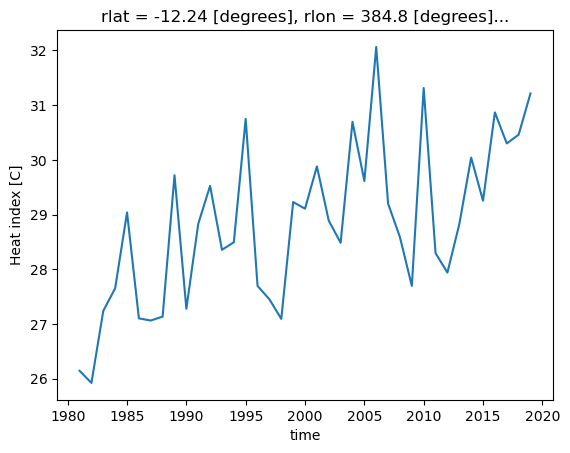

In [4]:
# NBVAL_IGNORE_OUTPUT

from xclim import atmos

# Compute heat index using xclim and find the annual maxima.
with Client(**dask_kwargs) as c:
    clear_output()
    hi_max = atmos.heat_index(ds=site).resample(time="Y").max()
clear_output()

# Plot the results
hi_max.plot()

## Visualization

Finally, we show how plot the CaSR data on a map. We need to specify two projections: one for the map, and another for the data. The Cartopy library is then able to connect data coordinates to map coordinates. 

Here for simplicity we'll use the regular lat-lon projection, called `PlateCarree`. Other choices would be `Orthographic` for a remote sensing view of the Earth, or `LambertConformal`, a projection often used for Canada-wide maps. 

The details of the data coordinate reference system are stored for convenience within the `rotated_pole` variable' attributes. 

In [5]:
bbox.rotated_pole

<xarray.DataArray 'rotated_pole' ()> Size: 4B
array(9.96921e+36, dtype=float32)
Coordinates:
    rotated_pole  float32 4B 9.969e+36
Attributes:
    long_name:                    coordinates of the rotated North Pole
    earth_radius:                 6371220.0
    grid_mapping_name:            rotated_latitude_longitude
    grid_north_pole_latitude:     31.758316040039062
    grid_north_pole_longitude:    87.59703063964844
    longitude_of_prime_meridian:  0.0
    north_pole_grid_longitude:    0.0

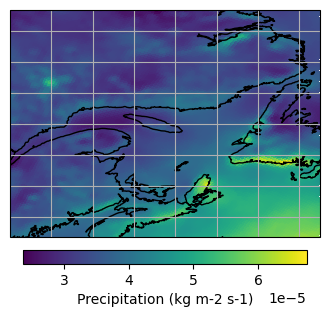

In [6]:
import cartopy.crs as ccrs

# A regular lat-lon projection for the map
pc = ccrs.PlateCarree()

# The coordinate reference system for the rotated pole data
rotp = ccrs.RotatedPole(
    pole_longitude=bbox.rotated_pole.grid_north_pole_longitude,
    pole_latitude=bbox.rotated_pole.grid_north_pole_latitude,
)

# Plot rotated pole data on a regular lat lon grid.
fig = plt.figure(figsize=(4, 4))

# Here we specify the map projection
ax = plt.subplot(1, 1, 1, projection=pc)
ax.set_extent(lon_bnds + lat_bnds)

# Here we specify the transformation required to map data coordinates to map coordinates.
m = ax.pcolormesh(pr10y.rlon, pr10y.rlat, pr10y, transform=rotp)

# Fine-tuning
ax.coastlines()
ax.gridlines()
plt.colorbar(
    m,
    orientation="horizontal",
    label=f"{pr10y.long_name} ({pr10y.units})",
    fraction=0.046,
    pad=0.04,
)